In [1]:
import findspark
findspark.init('/home/ubuntu/spark-3.2.1-bin-hadoop2.7')
import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('BDSA').getOrCreate()

Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/05/23 09:58:24 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
df = spark.read.csv('Heart_health.csv', inferSchema=True, header=True)
df.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Height(cm): integer (nullable = true)
 |-- Weight(kg): integer (nullable = true)
 |-- Blood Pressure(mmHg): string (nullable = true)
 |-- Cholesterol(mg/dL): integer (nullable = true)
 |-- Glucose(mg/dL): integer (nullable = true)
 |-- Smoker: string (nullable = true)
 |-- Exercise(hours/week): integer (nullable = true)
 |-- Heart Attack: integer (nullable = true)



In [3]:
df.show()

+---+------------------+---+------+----------+----------+--------------------+------------------+--------------+------+--------------------+------------+
| ID|              Name|Age|Gender|Height(cm)|Weight(kg)|Blood Pressure(mmHg)|Cholesterol(mg/dL)|Glucose(mg/dL)|Smoker|Exercise(hours/week)|Heart Attack|
+---+------------------+---+------+----------+----------+--------------------+------------------+--------------+------+--------------------+------------+
|  1|          John Doe| 45|  Male|       175|        80|              120/80|               200|            90|    No|                   3|           0|
|  2|        Jane Smith| 35|Female|       160|        65|              110/70|               180|            80|    No|                   2|           0|
|  3|   Michael Johnson| 55|  Male|       180|        85|              130/85|               220|            95|   Yes|                   4|           1|
|  4|       Sarah Brown| 40|Female|       165|        70|              115/7

In [4]:
gender_counts = df.groupBy("Gender").count()
gender_counts.show()

+------+-----+
|Gender|count|
+------+-----+
|Female|  362|
|  Male|  362|
+------+-----+



In [5]:
from pyspark.sql import functions as F

bins = [30, 35, 40, 45, 50, 55, 60]

conditions = [
    (df['Age'] >= bins[i]) & (df['Age'] < bins[i + 1]) for i in range(len(bins) - 1)
]
labels = [f"[{bins[i]}, {bins[i + 1]})" for i in range(len(bins) - 1)]

df = df.withColumn(
    'age_bin',
    F.when(conditions[0], labels[0])
)

for condition, label in zip(conditions[1:], labels[1:]):
    df = df.withColumn(
        'age_bin',
        F.when(condition, label).otherwise(df['age_bin'])
    )

age_bin_counts = df.groupBy('age_bin').count().orderBy('age_bin')

age_bin_counts.show()

+--------+-----+
| age_bin|count|
+--------+-----+
|    null|    5|
|[30, 35)|   75|
|[35, 40)|  151|
|[40, 45)|  139|
|[45, 50)|  134|
|[50, 55)|   92|
|[55, 60)|  128|
+--------+-----+



In [6]:
attack_counts = df.groupBy("Heart Attack").count()
attack_counts.show()

+------------+-----+
|Heart Attack|count|
+------------+-----+
|           1|  434|
|           0|  290|
+------------+-----+



In [7]:
import matplotlib.pyplot as plt

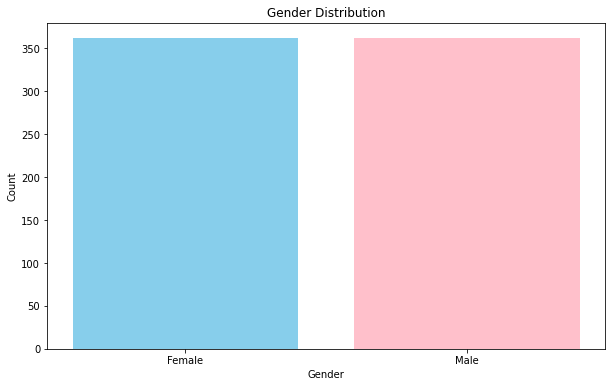

In [8]:
local_gender_counts = gender_counts.collect()

genders = [row['Gender'] for row in local_gender_counts]
counts = [row['count'] for row in local_gender_counts]

plt.figure(figsize=(10, 6))
plt.bar(genders, counts, color=['skyblue', 'pink'])
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution')
plt.xticks(rotation=0)  
plt.show()

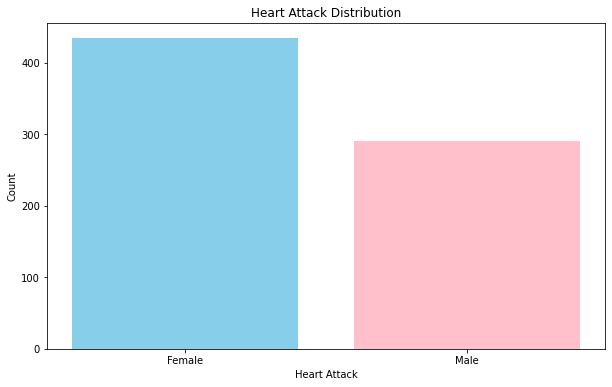

In [9]:
local_attack_counts = attack_counts.collect()

attack = [row['Heart Attack'] for row in local_attack_counts]
counts = [row['count'] for row in local_attack_counts]

plt.figure(figsize=(10, 6))
plt.bar(genders, counts, color=['skyblue', 'pink'])
plt.xlabel('Heart Attack')
plt.ylabel('Count')
plt.title('Heart Attack Distribution')
plt.xticks(rotation=0)  
plt.show()

In [10]:
df1 = spark.read.csv('Heart_health111.csv', inferSchema=True, header=True)
df1.printSchema()

root
 |-- ID: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Height(cm): integer (nullable = true)
 |-- Weight(kg): integer (nullable = true)
 |-- Blood Pressure(mmHg): string (nullable = true)
 |-- Cholesterol(mg/dL): integer (nullable = true)
 |-- Glucose(mg/dL): integer (nullable = true)
 |-- Smoker: string (nullable = true)
 |-- Exercise(hours/week): integer (nullable = true)
 |-- Heart Attack: integer (nullable = true)



In [11]:
df1.show()

+---+------------------+----+------+----------+----------+--------------------+------------------+--------------+------+--------------------+------------+
| ID|              Name| Age|Gender|Height(cm)|Weight(kg)|Blood Pressure(mmHg)|Cholesterol(mg/dL)|Glucose(mg/dL)|Smoker|Exercise(hours/week)|Heart Attack|
+---+------------------+----+------+----------+----------+--------------------+------------------+--------------+------+--------------------+------------+
|  1|          John Doe|  45|  Male|       175|        80|              120/80|               200|            90|    No|                   3|           0|
|  2|        Jane Smith|  35|Female|       160|        65|              110/70|               180|            80|    No|                   2|           0|
|  3|   Michael Johnson|  55|  Male|       180|        85|              130/85|               220|            95|   Yes|                   4|           1|
|  4|       Sarah Brown|  40|Female|       165|        70|            

In [12]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window

df_with_index = df1.withColumn("row_index", F.monotonically_increasing_id())

filtered_df = df_with_index.filter((F.col("row_index") >= 40) & (F.col("row_index") < 61))

filtered_df.show(filtered_df.count(), truncate=False)

+---+-------------------+---+------+----------+----------+--------------------+------------------+--------------+------+--------------------+------------+---------+
|ID |Name               |Age|Gender|Height(cm)|Weight(kg)|Blood Pressure(mmHg)|Cholesterol(mg/dL)|Glucose(mg/dL)|Smoker|Exercise(hours/week)|Heart Attack|row_index|
+---+-------------------+---+------+----------+----------+--------------------+------------------+--------------+------+--------------------+------------+---------+
|41 |Christopher Garcia |53 |Male  |174       |82        |124/78              |215               |94            |No    |3                   |1           |40       |
|42 |Sarah Nguyen       |41 |Female|167       |73        |121/77              |205               |90            |Yes   |2                   |0           |41       |
|43 |Brandon Smith      |47 |Male  |179       |79        |126/82              |210               |92            |Yes   |3                   |1           |42       |
|44 |Amand

In [13]:
df = df.drop('ID', 'Name','age_bin')
df.show()

+---+------+----------+----------+--------------------+------------------+--------------+------+--------------------+------------+
|Age|Gender|Height(cm)|Weight(kg)|Blood Pressure(mmHg)|Cholesterol(mg/dL)|Glucose(mg/dL)|Smoker|Exercise(hours/week)|Heart Attack|
+---+------+----------+----------+--------------------+------------------+--------------+------+--------------------+------------+
| 45|  Male|       175|        80|              120/80|               200|            90|    No|                   3|           0|
| 35|Female|       160|        65|              110/70|               180|            80|    No|                   2|           0|
| 55|  Male|       180|        85|              130/85|               220|            95|   Yes|                   4|           1|
| 40|Female|       165|        70|              115/75|               190|            85|    No|                   3|           0|
| 50|  Male|       170|        75|              125/80|               210|         

In [14]:
age_mean = df.select(F.mean('Age')).collect()[0][0]
df = df.na.fill({'Age': age_mean})

height_mean = df.select(F.mean('Height(cm)')).collect()[0][0]
df = df.na.fill({'Height(cm)': height_mean})

In [15]:
null_counts = df.select([F.sum(F.col(c).isNull().cast("int")).alias(c) for c in df.columns])
null_counts.show()

+---+------+----------+----------+--------------------+------------------+--------------+------+--------------------+------------+
|Age|Gender|Height(cm)|Weight(kg)|Blood Pressure(mmHg)|Cholesterol(mg/dL)|Glucose(mg/dL)|Smoker|Exercise(hours/week)|Heart Attack|
+---+------+----------+----------+--------------------+------------------+--------------+------+--------------------+------------+
|  0|     0|         0|         0|                   0|                 0|             0|     0|                   0|           0|
+---+------+----------+----------+--------------------+------------------+--------------+------+--------------------+------------+



In [16]:
df = df.na.replace(['M', 'F'], ['Male', 'Female'], 'Gender')

In [17]:
unique_genders = df.select("Gender").distinct()
unique_genders.show()

+------+
|Gender|
+------+
|Female|
|  Male|
+------+



In [18]:
# Split the 'Blood Pressure (mmHg)' column and create a new one
df = df.withColumn("High Blood Pressure(mmHg)", F.split(F.col("Blood Pressure(mmHg)"), "/")[0].cast("int"))
df = df.withColumn("Low Blood Pressure(mmHg)", F.split(F.col("Blood Pressure(mmHg)"), "/")[1].cast("int"))
# Delete the original 'Blood Pressure (mmHg)' column
df = df.drop("Blood Pressure(mmHg)")
df.show()

+---+------+----------+----------+------------------+--------------+------+--------------------+------------+-------------------------+------------------------+
|Age|Gender|Height(cm)|Weight(kg)|Cholesterol(mg/dL)|Glucose(mg/dL)|Smoker|Exercise(hours/week)|Heart Attack|High Blood Pressure(mmHg)|Low Blood Pressure(mmHg)|
+---+------+----------+----------+------------------+--------------+------+--------------------+------------+-------------------------+------------------------+
| 45|  Male|       175|        80|               200|            90|    No|                   3|           0|                      120|                      80|
| 35|Female|       160|        65|               180|            80|    No|                   2|           0|                      110|                      70|
| 55|  Male|       180|        85|               220|            95|   Yes|                   4|           1|                      130|                      85|
| 40|Female|       165|        70|

In [19]:
BMI = df.select((df["Weight(kg)"] / (df["Height(cm)"] / 100) ** 2).alias("BMI"))
BMI.show()

+------------------+
|               BMI|
+------------------+
|26.122448979591837|
|25.390624999999996|
|26.234567901234566|
| 25.71166207529844|
| 25.95155709342561|
| 24.97398543184183|
|26.775510204081634|
|25.910684346898332|
| 24.61810377477591|
|25.510204081632658|
|26.395803401383272|
|25.153150229218223|
| 26.56683975365294|
| 25.21735857578381|
|26.149276859504134|
|25.236340330075304|
|26.555965935105768|
|25.654372397382513|
| 25.53544639152223|
| 25.76571345623458|
+------------------+
only showing top 20 rows



In [20]:
df = df.withColumn("BMI", df["Weight(kg)"] / (df["Height(cm)"] / 100) ** 2)
df.show()

+---+------+----------+----------+------------------+--------------+------+--------------------+------------+-------------------------+------------------------+------------------+
|Age|Gender|Height(cm)|Weight(kg)|Cholesterol(mg/dL)|Glucose(mg/dL)|Smoker|Exercise(hours/week)|Heart Attack|High Blood Pressure(mmHg)|Low Blood Pressure(mmHg)|               BMI|
+---+------+----------+----------+------------------+--------------+------+--------------------+------------+-------------------------+------------------------+------------------+
| 45|  Male|       175|        80|               200|            90|    No|                   3|           0|                      120|                      80|26.122448979591837|
| 35|Female|       160|        65|               180|            80|    No|                   2|           0|                      110|                      70|25.390624999999996|
| 55|  Male|       180|        85|               220|            95|   Yes|                   4|    

In [21]:
df = df.withColumn("Gender", 
                   F.when(F.col("Gender") == "Male", 1)
                   .when(F.col("Gender") == "Female", 2)
                   .otherwise(F.col("Gender")))

df = df.withColumn("Smoker", 
                   F.when(F.col("Smoker") == "No", 0)
                   .when(F.col("Smoker") == "Yes", 1)
                   .otherwise(F.col("Smoker")))

df.show()

+---+------+----------+----------+------------------+--------------+------+--------------------+------------+-------------------------+------------------------+------------------+
|Age|Gender|Height(cm)|Weight(kg)|Cholesterol(mg/dL)|Glucose(mg/dL)|Smoker|Exercise(hours/week)|Heart Attack|High Blood Pressure(mmHg)|Low Blood Pressure(mmHg)|               BMI|
+---+------+----------+----------+------------------+--------------+------+--------------------+------------+-------------------------+------------------------+------------------+
| 45|     1|       175|        80|               200|            90|     0|                   3|           0|                      120|                      80|26.122448979591837|
| 35|     2|       160|        65|               180|            80|     0|                   2|           0|                      110|                      70|25.390624999999996|
| 55|     1|       180|        85|               220|            95|     1|                   4|    

In [22]:
df = df.drop('Height(cm)', 'Weight(kg)')
df.show()

+---+------+------------------+--------------+------+--------------------+------------+-------------------------+------------------------+------------------+
|Age|Gender|Cholesterol(mg/dL)|Glucose(mg/dL)|Smoker|Exercise(hours/week)|Heart Attack|High Blood Pressure(mmHg)|Low Blood Pressure(mmHg)|               BMI|
+---+------+------------------+--------------+------+--------------------+------------+-------------------------+------------------------+------------------+
| 45|     1|               200|            90|     0|                   3|           0|                      120|                      80|26.122448979591837|
| 35|     2|               180|            80|     0|                   2|           0|                      110|                      70|25.390624999999996|
| 55|     1|               220|            95|     1|                   4|           1|                      130|                      85|26.234567901234566|
| 40|     2|               190|            85|     0

In [23]:
columns = df.columns
columns.remove("Heart Attack")

for col in columns:
    df = df.withColumn(col, df[col].cast("double"))

correlations = {}
for col in columns:
    correlation = df.stat.corr("Heart Attack", col)
    correlations[col] = correlation

In [24]:
correlations

{'Age': 0.6135043981502403,
 'Gender': -0.5693869455152482,
 'Cholesterol(mg/dL)': 0.8271098772273353,
 'Glucose(mg/dL)': 0.7925246891216352,
 'Smoker': 0.03042162445802788,
 'Exercise(hours/week)': 0.6049508476532114,
 'High Blood Pressure(mmHg)': 0.7187043754703035,
 'Low Blood Pressure(mmHg)': 0.7545154370174629,
 'BMI': 0.5710877423402501}

In [25]:
df = df.drop('Smoker')
df.show()

+----+------+------------------+--------------+--------------------+------------+-------------------------+------------------------+------------------+
| Age|Gender|Cholesterol(mg/dL)|Glucose(mg/dL)|Exercise(hours/week)|Heart Attack|High Blood Pressure(mmHg)|Low Blood Pressure(mmHg)|               BMI|
+----+------+------------------+--------------+--------------------+------------+-------------------------+------------------------+------------------+
|45.0|   1.0|             200.0|          90.0|                 3.0|           0|                    120.0|                    80.0|26.122448979591837|
|35.0|   2.0|             180.0|          80.0|                 2.0|           0|                    110.0|                    70.0|25.390624999999996|
|55.0|   1.0|             220.0|          95.0|                 4.0|           1|                    130.0|                    85.0|26.234567901234566|
|40.0|   2.0|             190.0|          85.0|                 3.0|           0|       

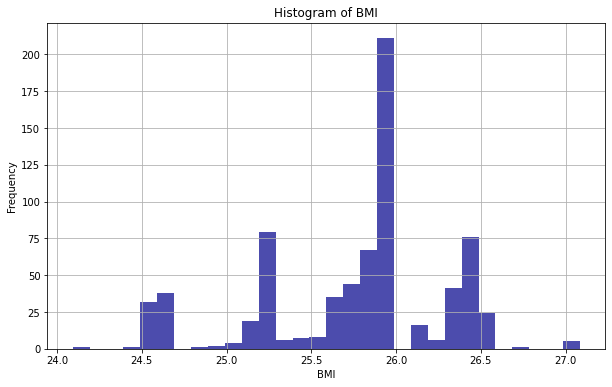

In [26]:
plt.figure(figsize=(10, 6))
plt.hist(df.select("BMI").toPandas(), bins=30, color='darkblue', alpha=0.7)
plt.title('Histogram of BMI')
plt.xlabel('BMI')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [27]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.sql.functions import col
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd

In [28]:
# Delete target column and create feature vector
feature_columns = [c for c in df.columns if c != 'Heart Attack']
assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")

# Convert target variable to label
df = df.withColumn("label", col("Heart Attack").cast("double"))

# Using VectorAssembler to convert features into a single feature vector
df = assembler.transform(df)

In [29]:
# partitioned data set
(train_data, test_data) = df.randomSplit([0.7, 0.3], seed=42)

In [30]:
train_data.show(5)

+----+------+------------------+--------------+--------------------+------------+-------------------------+------------------------+------------------+-----+--------------------+
| Age|Gender|Cholesterol(mg/dL)|Glucose(mg/dL)|Exercise(hours/week)|Heart Attack|High Blood Pressure(mmHg)|Low Blood Pressure(mmHg)|               BMI|label|            features|
+----+------+------------------+--------------+--------------------+------------+-------------------------+------------------------+------------------+-----+--------------------+
|30.0|   2.0|             170.0|          75.0|                 1.0|           0|                    105.0|                    65.0| 24.97398543184183|  0.0|[30.0,2.0,170.0,7...|
|30.0|   2.0|             180.0|          80.0|                 2.0|           0|                    110.0|                    70.0|25.390624999999996|  0.0|[30.0,2.0,180.0,8...|
|30.0|   2.0|             210.0|          92.0|                 4.0|           1|                    124.

In [31]:
test_data.show(5)

+----+------+------------------+--------------+--------------------+------------+-------------------------+------------------------+------------------+-----+--------------------+
| Age|Gender|Cholesterol(mg/dL)|Glucose(mg/dL)|Exercise(hours/week)|Heart Attack|High Blood Pressure(mmHg)|Low Blood Pressure(mmHg)|               BMI|label|            features|
+----+------+------------------+--------------+--------------------+------------+-------------------------+------------------------+------------------+-----+--------------------+
|30.0|   2.0|             210.0|          92.0|                 4.0|           1|                    124.0|                    79.0|26.332888752094664|  1.0|[30.0,2.0,210.0,9...|
|30.0|   2.0|             210.0|          92.0|                 4.0|           1|                    124.0|                    79.0|26.332888752094664|  1.0|[30.0,2.0,210.0,9...|
|30.0|   2.0|             210.0|          92.0|                 4.0|           1|                    124.

In [32]:
# Create SVM model
svm = LinearSVC(featuresCol="features", labelCol="label")

# training model
svm_model = svm.fit(train_data)

24/05/23 09:58:54 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/05/23 09:58:54 WARN InstanceBuilder$NativeBLAS: Failed to load implementation from:dev.ludovic.netlib.blas.ForeignLinkerBLAS


In [33]:
# Use test data for prediction and calculate the accuracy of the model.
predictions = svm_model.transform(test_data)

evaluator = BinaryClassificationEvaluator()
accuracy = evaluator.evaluate(predictions)
print("Accuracy:", accuracy)

prediction_errors = predictions.filter(predictions['label'] != predictions['prediction']).count()
print("Number of prediction errors:", prediction_errors)

Accuracy: 0.9998796340876264
Number of prediction errors: 1


In [34]:
from pyspark.ml.classification import LogisticRegression
# Create logistic regression model
lr = LogisticRegression(featuresCol="features", labelCol="label")

lr_model = lr.fit(train_data)

In [35]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(featuresCol="features", labelCol="label", maxIter=10, regParam=0.3, elasticNetParam=0.8)

lr_model = lr.fit(train_data)

In [36]:
# Use test data for prediction and calculate the accuracy of the model.
predictions = lr_model.transform(test_data)

evaluator = BinaryClassificationEvaluator()
accuracy = evaluator.evaluate(predictions)

print("Accuracy:", accuracy)

prediction_errors = predictions.filter(predictions['label'] != predictions['prediction']).count()
print("Number of prediction errors:", prediction_errors)

Accuracy: 0.9985556090515165
Number of prediction errors: 6


In [37]:
coefficients = lr_model.coefficients

feature_coefficients = pd.DataFrame({
    'Feature': feature_columns,
    'Coefficients': coefficients
})

print(feature_coefficients)

                     Feature  Coefficients
0                        Age      0.000000
1                     Gender      0.000000
2         Cholesterol(mg/dL)      0.033859
3             Glucose(mg/dL)      0.045999
4       Exercise(hours/week)      0.000000
5  High Blood Pressure(mmHg)      0.000000
6   Low Blood Pressure(mmHg)      0.026870
7                        BMI      0.000000


In [38]:
intercept = lr_model.intercept
print("Intercept:", intercept)

Intercept: -12.933107151490855


In [39]:
predictions = lr_model.transform(test_data)

evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC")
auc = evaluator.evaluate(predictions)
print("AUC:", auc)

AUC: 0.9985556090515165


In [40]:
training_summary = lr_model.summary

roc = training_summary.roc.toPandas()

/home/ubuntu/spark-3.2.1-bin-hadoop2.7/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


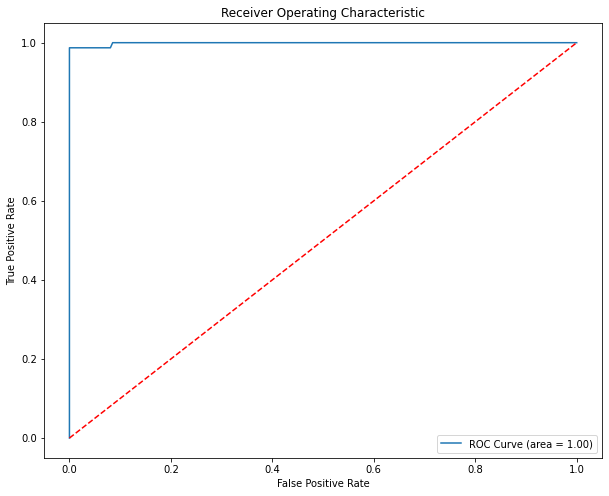

In [41]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
plt.plot(roc['FPR'], roc['TPR'], label='ROC Curve (area = %0.2f)' % training_summary.areaUnderROC)
plt.plot([0, 1], [0, 1], 'r--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [42]:
from pyspark.ml.classification import DecisionTreeClassifier
# Create decision tree model
tree_model = DecisionTreeClassifier(featuresCol="features", labelCol="label")

tree_model = tree_model.fit(train_data)

In [43]:
# Use test data for prediction and calculate the accuracy of the model.
predictions = tree_model.transform(test_data)

evaluator = BinaryClassificationEvaluator()
accuracy = evaluator.evaluate(predictions)

print("Accuracy:", accuracy)

prediction_errors = predictions.filter(predictions['label'] != predictions['prediction']).count()
print("Number of prediction errors:", prediction_errors)

Accuracy: 0.9959677419354839
Number of prediction errors: 1


In [44]:
from pyspark.ml.classification import RandomForestClassifier

# Define the RandomForest model
rf_model = RandomForestClassifier(featuresCol="features", labelCol="label", numTrees=20, seed=42)

# Train the model
rf_model = rf_model.fit(train_data)

In [45]:
# Use test data for prediction and calculate the accuracy of the model.
predictions = rf_model.transform(test_data)

evaluator = BinaryClassificationEvaluator()
accuracy = evaluator.evaluate(predictions)

print("Accuracy:", accuracy)

prediction_errors = predictions.filter(predictions['label'] != predictions['prediction']).count()
print("Number of prediction errors:", prediction_errors)

Accuracy: 1.0
Number of prediction errors: 1


In [46]:
feature_importances = rf_model.featureImportances.toArray()

feature_importance = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
})

print(feature_importance.sort_values(by='Importance', ascending=False))

                     Feature  Importance
3             Glucose(mg/dL)    0.363217
2         Cholesterol(mg/dL)    0.360650
5  High Blood Pressure(mmHg)    0.112387
6   Low Blood Pressure(mmHg)    0.079669
0                        Age    0.041169
7                        BMI    0.037347
4       Exercise(hours/week)    0.004900
1                     Gender    0.000661


In [47]:
tree_model = rf_model.trees[0]
tree_description = tree_model.toDebugString

print(tree_description)

DecisionTreeClassificationModel: uid=dtc_b2b7442df462, depth=2, numNodes=7, numClasses=2, numFeatures=8
  If (feature 3 <= 91.0)
   If (feature 5 <= 122.5)
    Predict: 0.0
   Else (feature 5 > 122.5)
    Predict: 1.0
  Else (feature 3 > 91.0)
   If (feature 2 <= 202.5)
    Predict: 0.0
   Else (feature 2 > 202.5)
    Predict: 1.0

